In [37]:
import pandas as pd
from skimage import io, transform, color
import os
from tqdm import tqdm
import numpy as np
import csv
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import cv2
from keras.models import Sequential, Model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from prettytable import PrettyTable
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Input
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import plot_model
%matplotlib inline
from keras.models import load_model

print(f'TensorFlow {tf.__version__}')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0])




TensorFlow 2.13.1
Num GPUs Available:  0


# **Loading of Data**

Loading the UTKFace data into a matrix, X is the data en y the shape (3,1) target

RAW Flatten for Feature Extractor

In [ ]:
errors = 0
image_path = 'UTKFace'

X = []
y = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))
        new_row = list(map(float, file.split("_")[:3]))
        y.append(new_row)
        color_image = color_image.reshape(-1).tolist()
        X.append(color_image)
    except Exception as e:
        errors += 1


In [33]:
print(len(X))
print(len(X[0]))

23705
120000


In [42]:
print(len(y))
print(len(y[0]))

23705
3


RAW Flatten

In [3]:
errors = 0
image_path = 'UTKFace'

FLATX = []
FLATy = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))
        new_row = list(map(float, file.split("_")[:3]))
        FLATy.append(new_row)
        FLATX.append(np.array(color_image).reshape(-1))
    except Exception as e:
        errors += 1

100%|██████████| 23708/23708 [02:42<00:00, 145.80it/s]


In [4]:
FLATX_np = np.array(FLATX)

In [5]:
FLATy_np = np.array(FLATy)

In [141]:
print(len(FLATX_np))
print(len(FLATX_np[0]))



23705
120000


RAW 3D

In [8]:
errors = 0
image_path = 'UTKFace'

X3D = []
y3D = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))/255.0
        color_image = transform.resize(color_image, (100, 100))
        new_row = list(map(float, file.split("_")[:3]))
        y3D.append(new_row)
        X3D.append(color_image)
    except Exception as e:
        errors += 1


100%|██████████| 23708/23708 [01:00<00:00, 388.67it/s]


In [ ]:
print(X3D)

In [9]:
X3D_np = np.array(X3D)

In [10]:
y3D_np = np.array(y3D)

In [6]:
print(len(X3D_np))
print(len(X3D_np[0]))
print(len(X3D_np[0,0]))
print(len(X3D_np[0,0,0]))

23705
100
100
3


# **Bilateral Filter**

Let's apply a Bilateral Filter to all the images

In [213]:
image_directory = 'UTKFace'

image_files = os.listdir(image_directory)

for image_file in tqdm(image_files):
    img = cv2.imread(os.path.join(image_directory, image_file))
    
    # Apply bilateral filter with d=15, sigmaColor=75, sigmaSpace=75
    bilateral = cv2.bilateralFilter(img, 15, 75, 75)
    
    cv2.imwrite(os.path.join("filtered_images", image_file), bilateral)

100%|██████████| 23708/23708 [04:44<00:00, 83.38it/s]


In [20]:
errors = 0
image_path = 'filtered_images'

FILTEREDX = []
FILTEREDy = []

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))/255.0
        new_row = list(map(float, file.split("_")[:3]))
        color_image = transform.resize(color_image, (100, 100))
        FILTEREDy.append(new_row)
        FILTEREDX.append(color_image)
    except Exception as e:
        errors += 1

100%|██████████| 23708/23708 [02:49<00:00, 139.57it/s]


In [21]:
FILTEREDX_np = np.array(FILTEREDX)

In [23]:
FILTEREDy_np = np.array(FILTEREDy)

In [22]:
print(len(FILTEREDX_np))
print(len(FILTEREDX_np[0]))
print(len(FILTEREDX_np[0,0]))
print(len(FILTEREDX_np[0,0,0]))

23705
100
100
3


# **Feature Extraction**

We performed a 1000 components PCA on the faltten data

In [34]:
pca = PCA(n_components=1000)
X_pca = pca.fit_transform(X)

In [35]:
print(len(X_pca))
print(len(X_pca[0]))

23705
1000


Let's save the processed data

In [36]:
np.savetxt("X_PCA_"+str(len(X_pca[0]))+"_components.csv", X_pca, delimiter=",")

In [12]:
np.savetxt("Target.csv", y, delimiter=",")

In [37]:
X = np.array(X_pca)
y = np.array(y)

When code isn't compiled, run this to load data with PCA

In [11]:
X = pd.read_csv('X_PCA_1000_components.csv').to_numpy()

In [12]:
y = pd.read_csv('Target.csv').to_numpy()

# **Data Analysis**

Feature Engineering


In [18]:
etnicity_dict = {0:'Caucasian', 1:'African', 2:'Asian' , 3:'Indian', 4:'Arabian'}

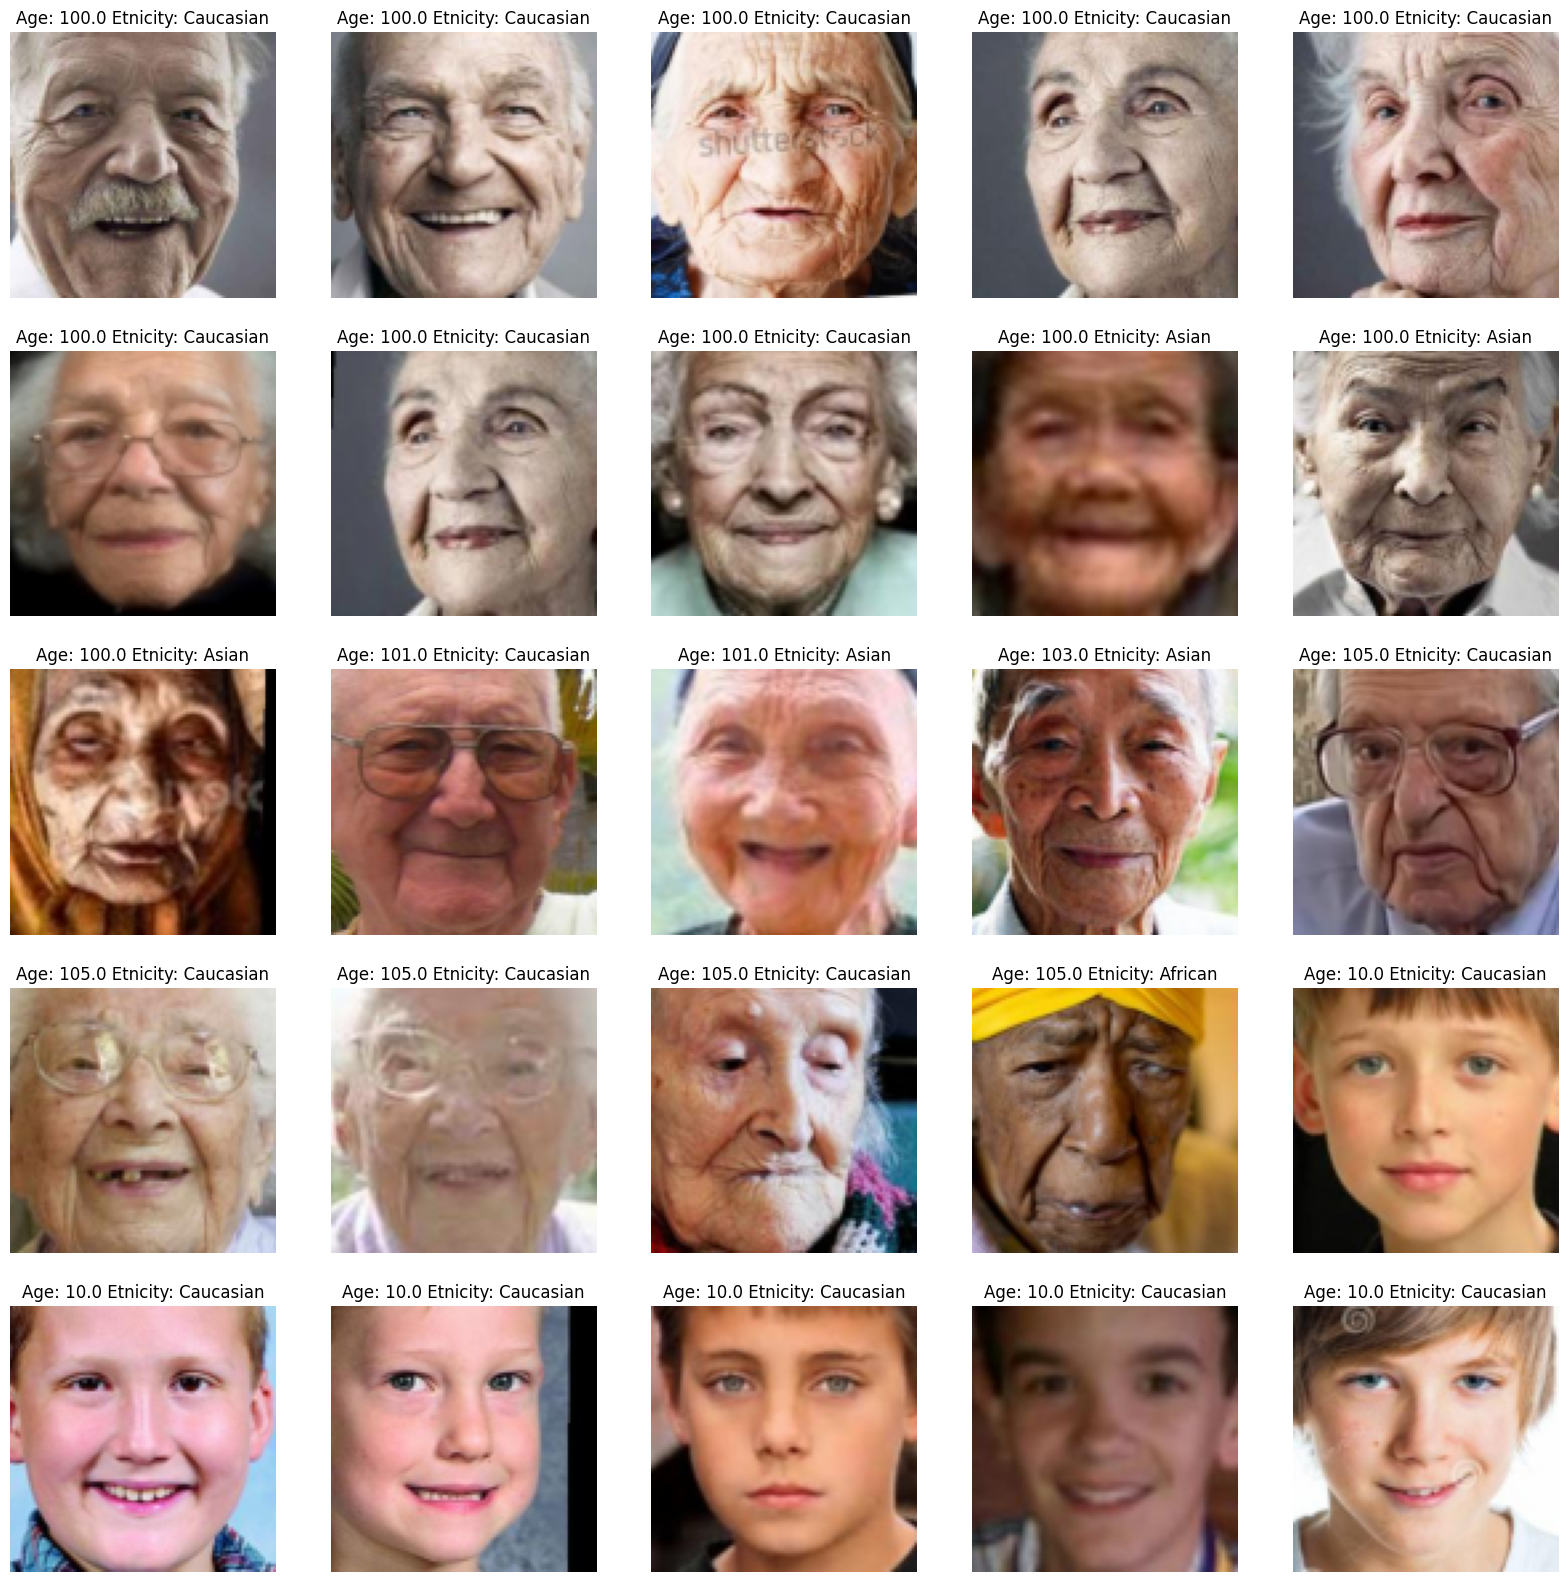

In [13]:
plt.figure(figsize=(20, 20))
images = X3D_np[0:25]

for index, image in enumerate(images):
    plt.subplot(5, 5, index+1)
    image = np.array(image)
    plt.imshow(image)
    plt.title(f"Age: {y3D_np.T[0][index]} Etnicity: {etnicity_dict[y3D_np.T[2][index]]}")
    plt.axis('off')

Null value checking

In [39]:
df = pd.DataFrame(X)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Columns: 1000 entries, 0 to 999
dtypes: float64(1000)
memory usage: 180.9 MB


In [40]:
df = pd.DataFrame(y)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23705 non-null  float64
 1   1       23705 non-null  float64
 2   2       23705 non-null  float64
dtypes: float64(3)
memory usage: 555.7 KB


Bias per class in the 3 variables

Age

In [105]:
df = pd.DataFrame(y)
df[0].value_counts()

0
26.0     2197
1.0      1123
28.0      918
35.0      880
24.0      859
         ... 
115.0       3
91.0        2
101.0       2
103.0       1
111.0       1
Name: count, Length: 104, dtype: int64

C:\Users\geogd\AppData\Local\Temp\ipykernel_19764\3624736495.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[0], palette="Set1")


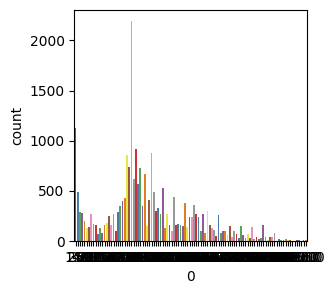

In [86]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=df[0], palette="Set1")
plt.show()

C:\Users\geogd\AppData\Local\Temp\ipykernel_13672\3841527020.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[0])


<Axes: xlabel='0', ylabel='Density'>

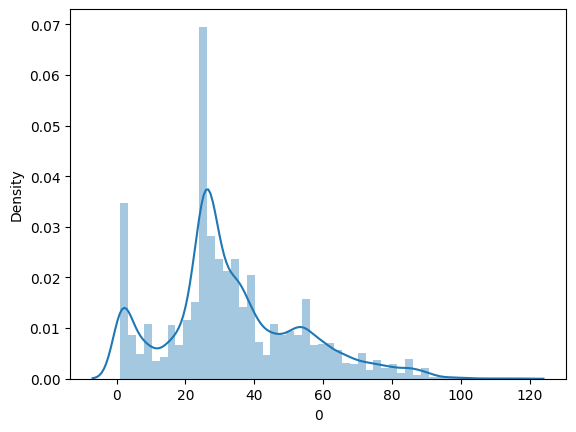

In [106]:
sns.distplot(df[0])

Gender

In [ ]:
df[1].value_counts()

1
0.0    12391
1.0    11314
Name: count, dtype: int64

C:\Users\geogd\AppData\Local\Temp\ipykernel_19764\3180355283.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[1], palette="Set1")


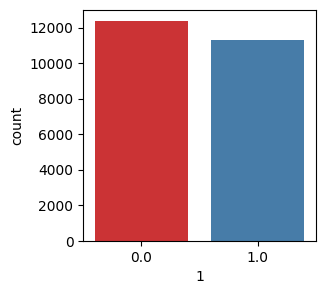

In [87]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=df[1], palette="Set1")
plt.show()

0 for men

1 for women

Race

In [ ]:
df[2].value_counts()

2
0.0    10078
1.0     4526
3.0     3975
2.0     3434
4.0     1692
Name: count, dtype: int64

C:\Users\geogd\AppData\Local\Temp\ipykernel_19764\3471218125.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[2], palette="Set1")


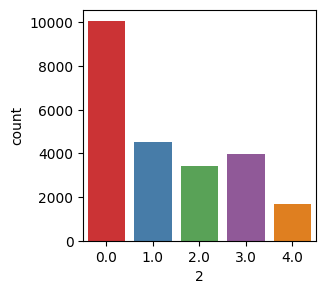

In [89]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=df[2], palette="Set1")
plt.show()

0 for caucasian

1 for african

2 for asian

3 for indian

4 for arabian

Duplicates

In [51]:
df = pd.DataFrame(X)
count_duplicates = df[df.duplicated()].shape[0]
print("Number of duplicate rows:", count_duplicates)

Number of duplicate rows: 303


Outliers

In [74]:
df = pd.DataFrame(X)
pca = PCA(n_components=2)
X_pca_to_plot = pca.fit_transform(df)


{'whiskers': [<matplotlib.lines.Line2D at 0x14f0855bc10>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x14f07651190>,
  ...],
 'boxes': [<matplotlib.lines.Line2D at 0x14f0855bd50>,
  ...],
 'medians': [<matplotlib.lines.Line2D at 0x14f07652310>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x14f07650990>,
  ...],
 'means': []}

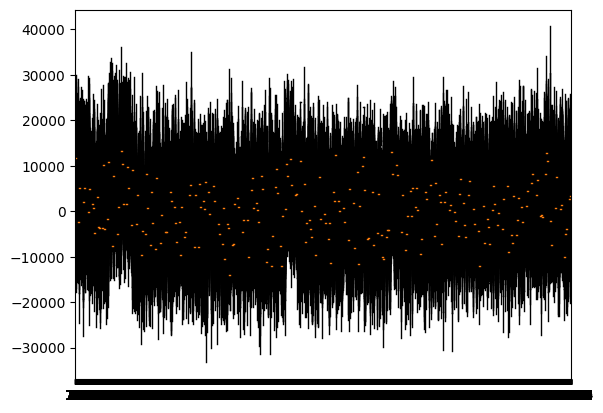

In [94]:
plt.boxplot(X_pca_to_plot.T)

# **Sampling Data**

Feature Engineering

Feature Extracted

In [13]:
df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)

df_X[len(df_X.columns)] = df_y.iloc[:, 0]  # Add the first column from df_y to df_X
df_X[len(df_X.columns)] = df_y.iloc[:, 1]  # Add the second column from df_y to df_X

rus = RandomUnderSampler(sampling_strategy={0.0: 5000}, random_state=45)
X_sm, y_sm = rus.fit_resample(df_X, df_y[2])

X_sm = pd.DataFrame(X_sm)
y_sm = pd.DataFrame(y_sm)

y_sm[len(y_sm.columns)-1] = X_sm.iloc[:, -2]  # Add the second last column from X_sm to y_sm
y_sm[len(y_sm.columns)-1] = X_sm.iloc[:, -1]  # Add the last column from X_sm to y_sm

X_sm = X_sm.iloc[:, :-2]

first_column = y_sm.columns[0]
y_sm[first_column] = y_sm.pop(first_column)
y_sm["2"] = first_column
y_sm = y_sm.iloc[:, :-1]

index_list = y_sm.index.tolist()


In [120]:
print(X_sm)

                0            1            2            3            4    \
18377   2296.076508 -1862.353361 -1225.816727 -3484.615567 -3318.919041   
21946   6383.955612 -1431.902605  5851.377249 -6655.786278   -15.376132   
21071   7925.125834 -4800.398440 -8328.776212 -3051.826755 -3352.779244   
23507  15316.718215  7028.715548 -1002.286979 -4512.399714  1567.161942   
5856    9186.421765  1653.202289 -2050.579457  1697.777770  3337.469566   
...             ...          ...          ...          ...          ...   
23672 -13320.395261  5969.382904  5982.558307  4670.958813 -2884.429090   
23673  -4920.917868 -4034.593984  5101.058227  2575.320812  -595.430114   
23701  15546.410828 -2920.783906  1319.805393  4600.437843 -1830.383603   
23702   5650.698783 -5956.548888 -8157.927524  3332.458271 -2883.382598   
23703  10661.937162  -661.109964   500.723816   497.227619 -2505.362284   

               5            6            7            8            9    ...  \
18377 -2345.497392  

In [121]:
print(y_sm)

          0    1    2
18377  52.0  0.0  0.0
21946  71.0  0.0  0.0
21071  64.0  1.0  0.0
23507  95.0  1.0  0.0
5856   26.0  0.0  0.0
...     ...  ...  ...
23672   9.0  0.0  4.0
23673   9.0  0.0  4.0
23701   9.0  1.0  4.0
23702   9.0  1.0  4.0
23703   9.0  1.0  4.0

[18627 rows x 3 columns]


C:\Users\geogd\AppData\Local\Temp\ipykernel_13672\3597133842.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_sm[2], palette="Set1")


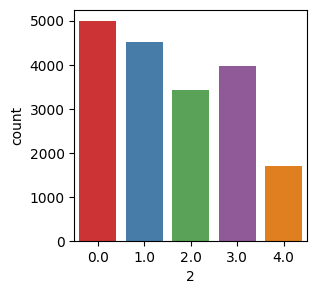

In [122]:
f, ax = plt.subplots(figsize=(3, 3))
ax = sns.countplot(x=y_sm[2], palette="Set1")
plt.show()

RAW 3D

In [14]:
X3D_np, y3D_np = X3D_np[index_list], y3D_np[index_list]

RAW Flatten

In [16]:
FLATX_np, FLATy_np = FLATX_np[index_list], FLATy_np[index_list]

Bilateral Filter

In [24]:
FILTEREDX_np, FILTEREDy_np = FILTEREDX_np[index_list], FILTEREDy_np[index_list]

# **Data Split**

Feature Extracted

In [18]:
min_val = X_sm.min(axis=0)
max_val = X_sm.max(axis=0)
X_sm = (X_sm - min_val) / (max_val - min_val)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, shuffle=False)

RAW Flatten

In [21]:
FLATX_train, FLATX_test, FLATy_train, FLATy_test = train_test_split(FLATX_np, FLATy_np.T[0], test_size=0.2, random_state=45)

# **Models**

**MLP**

In [139]:
input_shape = (100, 100, 3)
inputs = Input((input_shape))

flatten = Flatten() (inputs)

dense_1 = Dense(1024, activation='relu') (flatten)
dense_2 = Dense(1024, activation='relu') (dense_1)
dense_3 = Dense(1024, activation='relu') (dense_2)

output_2 = Dense(117, activation='softmax', name='age_out') (dense_3)

MLP = Model(inputs=[inputs], outputs=[output_2])

MLP.compile(loss=['sparse_categorical_crossentropy', 'mae','mse'], optimizer='adam', metrics=['accuracy'])

**CNN Model One**

In [127]:
input_shape = (100, 100, 3)

inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(5, activation='softmax', name='ethnicity_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

CNNOne = Model(inputs=[inputs], outputs=[output_1, output_2])

CNNOne.compile(loss=['sparse_categorical_crossentropy', 'mae','mse'], optimizer='adam', metrics=['accuracy'])

**CNN Model Two**

In [15]:
input_shape = (100, 100, 3)

inputs = Input((input_shape))
conv_1 = Conv2D(25, kernel_size=(5, 5), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(50, kernel_size=(5, 5), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(100, kernel_size=(5, 5), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(200, kernel_size=(5, 5), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(200, activation='relu') (flatten)
dense_2 = Dense(200, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(5, activation='softmax', name='ethnicity_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

CNNTwo = Model(inputs=[inputs], outputs=[output_1, output_2])

CNNTwo.compile(loss=['sparse_categorical_crossentropy', 'mae','mse'], optimizer='adam', metrics=['accuracy'])

# **Tests**

**MLP RAW**

In [142]:
history = MLP.fit(x=X3D_np, y=y3D_np.T[0], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
466/466 [==============================] - 51s 109ms/step - loss: 3.5340 - accuracy: 0.1633 - val_loss: 4.0880 - val_accuracy: 0.0786
Epoch 2/30
466/466 [==============================] - 51s 110ms/step - loss: 3.4903 - accuracy: 0.1680 - val_loss: 3.8247 - val_accuracy: 0.0794
Epoch 3/30
466/466 [==============================] - 52s 112ms/step - loss: 3.4792 - accuracy: 0.1680 - val_loss: 4.0090 - val_accuracy: 0.0770
Epoch 4/30
466/466 [==============================] - 53s 113ms/step - loss: 3.4756 - accuracy: 0.1656 - val_loss: 3.8688 - val_accuracy: 0.0829
Epoch 5/30
466/466 [==============================] - 51s 109ms/step - loss: 3.4189 - accuracy: 0.1684 - val_loss: 3.7952 - val_accuracy: 0.0811
Epoch 6/30
466/466 [==============================] - 53s 113ms/step - loss: 3.4083 - accuracy: 0.1692 - val_loss: 3.8535 - val_accuracy: 0.0819
Epoch 7/30
466/466 [==============================] - 53s 113ms/step - loss: 3.4095 - accuracy: 0.1697 - val_loss: 3.7964 - val_ac

In [143]:
MLP.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 flatten_40 (Flatten)        (None, 30000)             0         
                                                                 
 dense_112 (Dense)           (None, 1024)              30721024  
                                                                 
 dense_113 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_114 (Dense)           (None, 1024)              1049600   
                                                                 
 age_out (Dense)             (None, 117)               119925    
                                                                 
Total params: 32940149 (125.66 MB)
Trainable params: 32940

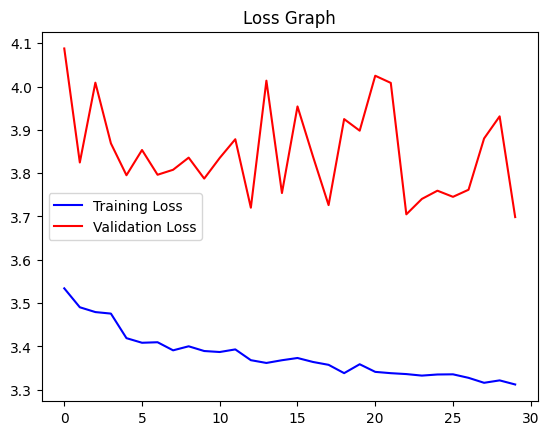

In [146]:
# plot results for age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

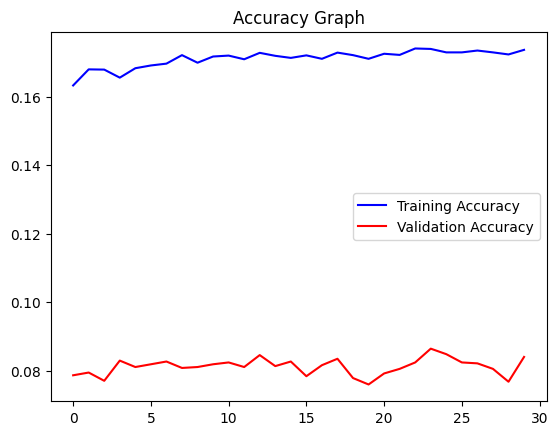

<Figure size 640x480 with 0 Axes>

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [148]:
MLP.save('MLP_RAW.h5')

**CNN Model One RAW**

In [ ]:
history = CNNOne.fit(x=X3D_np, y=[y3D_np.T[2], y3D_np.T[0]], batch_size=32, epochs=30, validation_split=0.2)

In [ ]:
CNNOne.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_36 (Conv2D)          (None, 98, 98, 32)           896       ['input_10[0][0]']            
                                                                                                  
 max_pooling2d_36 (MaxPooli  (None, 49, 49, 32)           0         ['conv2d_36[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_37 (Conv2D)          (None, 47, 47, 64)           18496     ['max_pooling2d_36[0][0]

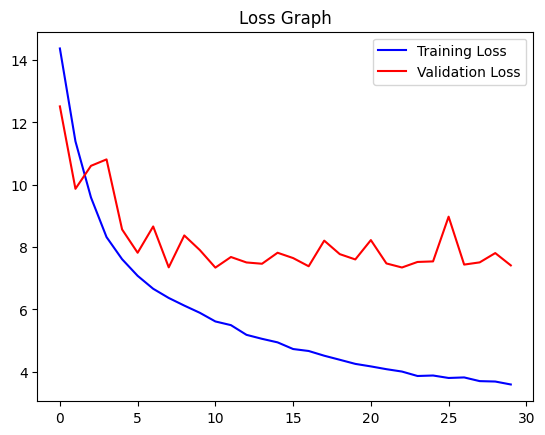

In [ ]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

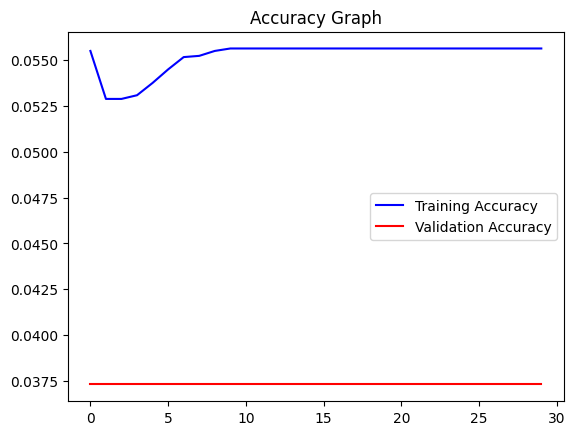

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [ ]:
CNNOne.save('CNNOne_RAW.h5')

**CNN Model One with filters**

In [27]:
history = CNNOne.fit(x=FILTEREDX_np, y=[FILTEREDy_np.T[2], FILTEREDy_np.T[0]], batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
466/466 [==============================] - 43s 92ms/step - loss: 24.0802 - ethnicity_out_loss: 4.2485 - age_out_loss: 19.8317 - ethnicity_out_accuracy: 0.3025 - age_out_accuracy: 0.0294 - val_loss: 13.3234 - val_ethnicity_out_loss: 2.6107 - val_age_out_loss: 10.7127 - val_ethnicity_out_accuracy: 0.0000e+00 - val_age_out_accuracy: 0.0325
Epoch 2/100
466/466 [==============================] - 44s 95ms/step - loss: 12.1795 - ethnicity_out_loss: 1.3591 - age_out_loss: 10.8204 - ethnicity_out_accuracy: 0.3487 - age_out_accuracy: 0.0172 - val_loss: 13.9122 - val_ethnicity_out_loss: 3.3155 - val_age_out_loss: 10.5967 - val_ethnicity_out_accuracy: 0.0016 - val_age_out_accuracy: 0.0064
Epoch 3/100
466/466 [==============================] - 44s 95ms/step - loss: 11.4432 - ethnicity_out_loss: 1.3337 - age_out_loss: 10.1095 - ethnicity_out_accuracy: 0.3594 - age_out_accuracy: 0.0105 - val_loss: 13.1080 - val_ethnicity_out_loss: 3.1384 - val_age_out_loss: 9.9696 - val_ethnicity_out_accu

In [11]:
CNNOne.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 98, 98, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 47, 47, 64)           18496     ['max_pooling2d[0][0]']   

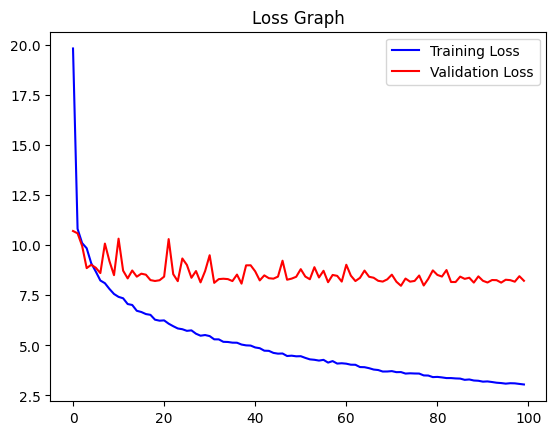

In [28]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

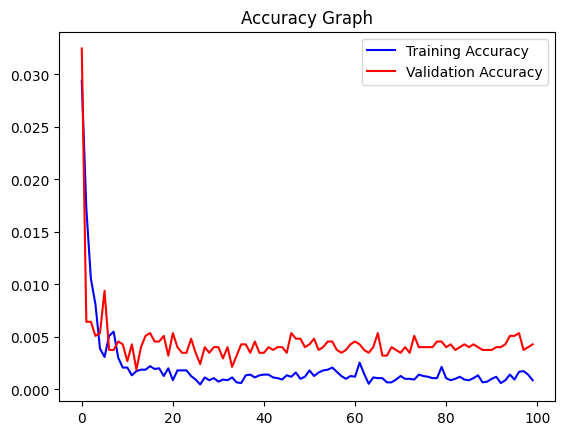

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [30]:
CNNOne.save('CNNOne_FILTER.h5')

**CNN Model Two RAW**

In [16]:
history = CNNTwo.fit(x=X3D_np, y=[y3D_np.T[2], y3D_np.T[0]], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
466/466 [==============================] - 58s 122ms/step - loss: 16.0080 - ethnicity_out_loss: 1.3941 - age_out_loss: 14.6139 - ethnicity_out_accuracy: 0.3362 - age_out_accuracy: 0.0555 - val_loss: 16.8717 - val_ethnicity_out_loss: 3.5594 - val_age_out_loss: 13.3123 - val_ethnicity_out_accuracy: 8.0515e-04 - val_age_out_accuracy: 0.0373
Epoch 2/30
466/466 [==============================] - 59s 128ms/step - loss: 13.8696 - ethnicity_out_loss: 1.2786 - age_out_loss: 12.5910 - ethnicity_out_accuracy: 0.4104 - age_out_accuracy: 0.0549 - val_loss: 14.0024 - val_ethnicity_out_loss: 3.9779 - val_age_out_loss: 10.0245 - val_ethnicity_out_accuracy: 0.0032 - val_age_out_accuracy: 0.0344
Epoch 3/30
466/466 [==============================] - 60s 129ms/step - loss: 11.3969 - ethnicity_out_loss: 1.1700 - age_out_loss: 10.2269 - ethnicity_out_accuracy: 0.5069 - age_out_accuracy: 0.0411 - val_loss: 12.2642 - val_ethnicity_out_loss: 3.6096 - val_age_out_loss: 8.6546 - val_ethnicity_out_accu

In [77]:
CNNTwo.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 96, 96, 25)           1900      ['input_16[0][0]']            
                                                                                                  
 max_pooling2d_60 (MaxPooli  (None, 48, 48, 25)           0         ['conv2d_60[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 44, 44, 50)           31300     ['max_pooling2d_60[0][0

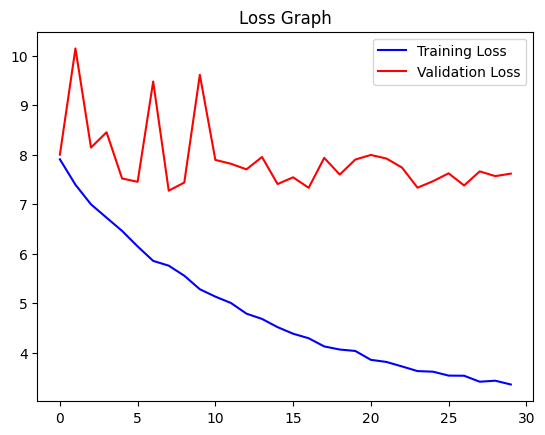

In [78]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

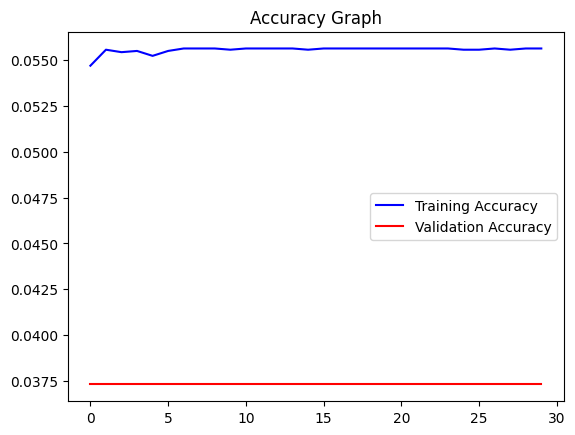

<Figure size 640x480 with 0 Axes>

In [79]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [80]:
CNNTwo.save('CNNTwo_RAW.h5')

**CNN Model Two with filters**

In [82]:
history = CNNTwo.fit(x=FILTEREDX_np, y=[FILTEREDy_np.T[2], FILTEREDy_np.T[0]], batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
466/466 [==============================] - 57s 123ms/step - loss: 4.1906 - ethnicity_out_loss: 0.2384 - age_out_loss: 3.9522 - ethnicity_out_accuracy: 0.9183 - age_out_accuracy: 0.0554 - val_loss: 12.3009 - val_ethnicity_out_loss: 4.7557 - val_age_out_loss: 7.5452 - val_ethnicity_out_accuracy: 0.2472 - val_age_out_accuracy: 0.0373
Epoch 2/100
466/466 [==============================] - 56s 119ms/step - loss: 3.9294 - ethnicity_out_loss: 0.2010 - age_out_loss: 3.7284 - ethnicity_out_accuracy: 0.9322 - age_out_accuracy: 0.0556 - val_loss: 12.6917 - val_ethnicity_out_loss: 4.7925 - val_age_out_loss: 7.8992 - val_ethnicity_out_accuracy: 0.2775 - val_age_out_accuracy: 0.0373
Epoch 3/100
466/466 [==============================] - 55s 118ms/step - loss: 3.8194 - ethnicity_out_loss: 0.1944 - age_out_loss: 3.6250 - ethnicity_out_accuracy: 0.9315 - age_out_accuracy: 0.0556 - val_loss: 12.8315 - val_ethnicity_out_loss: 4.8488 - val_age_out_loss: 7.9827 - val_ethnicity_out_accuracy: 0.2

In [83]:
CNNTwo.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv2d_60 (Conv2D)          (None, 96, 96, 25)           1900      ['input_16[0][0]']            
                                                                                                  
 max_pooling2d_60 (MaxPooli  (None, 48, 48, 25)           0         ['conv2d_60[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 44, 44, 50)           31300     ['max_pooling2d_60[0][0

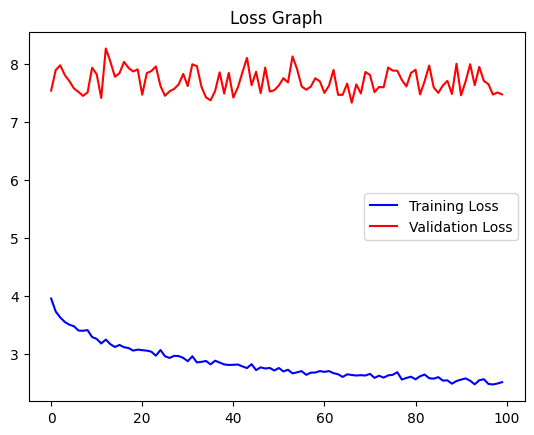

In [84]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

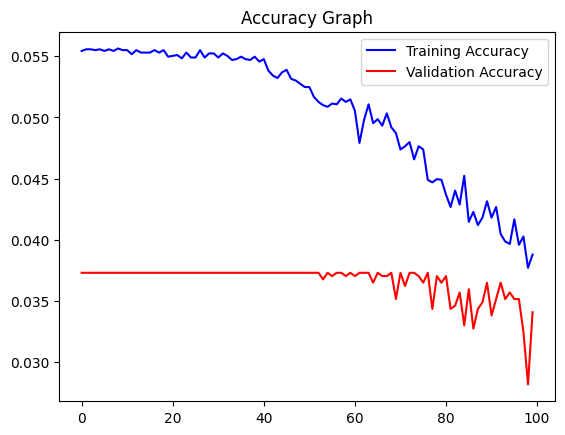

<Figure size 640x480 with 0 Axes>

In [85]:
acc = history.history['age_out_accuracy']
val_acc = history.history['val_age_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [86]:
CNNTwo.save('CNNTwo_FILTER.h5')

# **Predictions**

MLP RAW

Original Age: 37
1/1 [==============================] - 0s 17ms/step
[[1.44767149e-08 1.00639672e-03 4.81647548e-05 1.62749799e-04
  2.15129898e-04 1.76515174e-03 2.03097821e-04 9.77393240e-04
  2.28948030e-03 1.98222254e-03 9.36710101e-04 6.36897224e-04
  2.21355143e-03 1.08709035e-03 1.63163431e-03 2.40464625e-03
  3.50650284e-03 4.47250949e-03 4.89670271e-03 2.79802829e-03
  5.39997965e-03 6.02013897e-03 8.86963587e-03 8.09112843e-03
  1.52349947e-02 2.42031589e-02 7.72073567e-02 2.65273713e-02
  3.92211601e-02 2.45448928e-02 3.02933156e-02 2.17347238e-02
  5.11585996e-02 7.18920445e-03 2.20388640e-02 5.78983203e-02
  2.69068852e-02 2.31337249e-02 2.70311385e-02 1.93665400e-02
  3.97689268e-02 1.12004643e-02 2.73330305e-02 8.18941463e-03
  6.73025753e-03 3.10670920e-02 1.10807745e-02 8.58875830e-03
  9.00626276e-03 9.53648239e-03 2.51364075e-02 1.23627484e-02
  1.90328844e-02 1.35851828e-02 2.55936868e-02 1.48151359e-02
  1.41764944e-02 4.51663090e-03 1.51862064e-02 7.71056255e-03
 

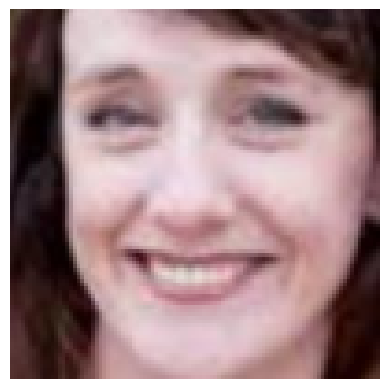

In [155]:
image_index = 12
print("Original Age:", int(y3D_np.T[0][image_index]))
# predict from model
pred = MLP.predict(np.array([X3D_np[image_index]]))
print(pred)
pred_age = round(pred[0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X3D_np[image_index], cmap='gray');

CNN One RAW

Original Ethnicity: Caucasian // Original Age: 37
1/1 [==============================] - 0s 14ms/step
Predicted Ethnicity: Caucasian // Predicted Age: 39


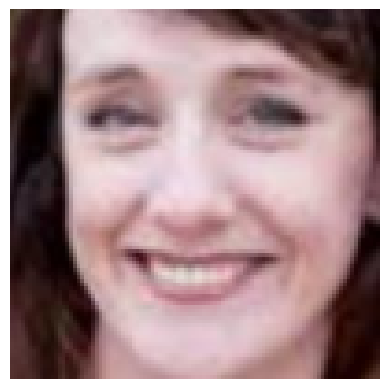

In [76]:
image_index = 12
print("Original Age:", int(y3D_np.T[0][image_index]))
# predict from model
pred = CNNOne.predict(np.array([X3D_np[image_index]]))
pred_eth = etnicity_dict[abs(round(pred[0][0][0])-1)]
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X3D_np[image_index], cmap='gray');

CNN One Filter

Original Ethnicity: Caucasian // Original Age: 37
1/1 [==============================] - 0s 24ms/step


Predicted Ethnicity: Caucasian // Predicted Age: 42


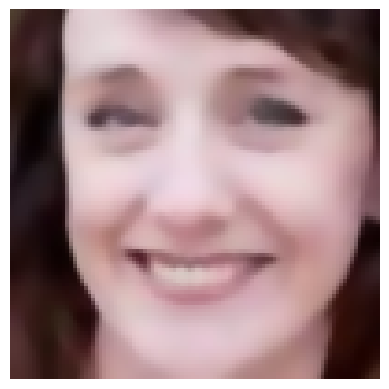

In [46]:
image_index = 12
print("Original Age:", int(FILTEREDy_np.T[0][image_index]))
# predict from model
pred = CNNOne.predict(np.array([FILTEREDX_np[image_index]]))
pred_eth = etnicity_dict[abs(round(pred[0][0][0])-1)]
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(FILTEREDX_np[image_index], cmap='gray');

CNN Two RAW

Test personal

In [43]:
Model = load_model('CNNTwo_RAW.h5')

In [44]:
images=[]
labels=[]
image_path='test'

for file in tqdm(os.listdir(image_path)):
    try:
        # Load, transform image
        color_image = np.array(io.imread(os.path.join(image_path, file)))/255.0
        color_image = transform.resize(color_image, (100, 100))
        new_row = list(map(float, file.split("_")[:3]))
        labels.append(new_row)
        images.append(color_image)
    except Exception as e:
        errors += 1

images=np.array(images)
labels=np.array(labels)

100%|██████████| 3/3 [00:00<00:00, 145.23it/s]


In [28]:
print(labels.T[0])

[21.]


Original Age: 81
1/1 [==============================] - 0s 21ms/step
Predicted Age: 62


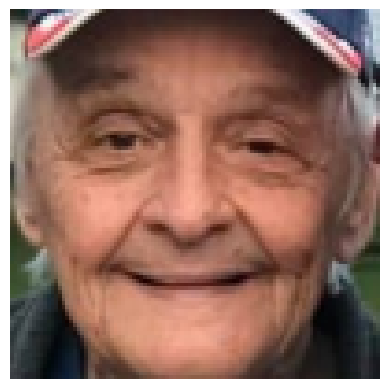

In [49]:
image_index = 2
print("Original Age:", int(labels.T[0][image_index]))
# predict from model
pred = Model.predict(np.array([images[image_index]]))
pred_eth = etnicity_dict[abs(round(pred[0][0][0])-1)]
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(images[image_index], cmap='gray');

Test datos

Original Age: 37
1/1 [==============================] - 0s 17ms/step
Predicted Age: 39


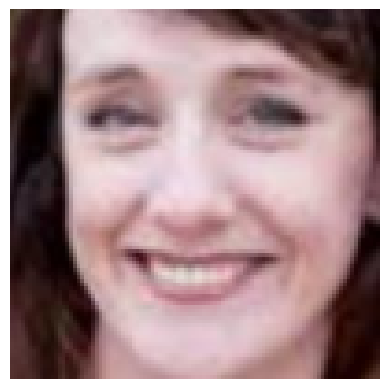

In [20]:
image_index = 12
print("Original Age:", int(y3D_np.T[0][image_index]))
# predict from model
pred = CNNTwo.predict(np.array([X3D_np[image_index]]))
pred_eth = etnicity_dict[abs(round(pred[0][0][0])-1)]
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X3D_np[image_index], cmap='gray');

CNN Two Filter

Original Ethnicity: Caucasian // Original Age: 37
1/1 [==============================] - 0s 20ms/step
Predicted Ethnicity: Caucasian // Predicted Age: 44


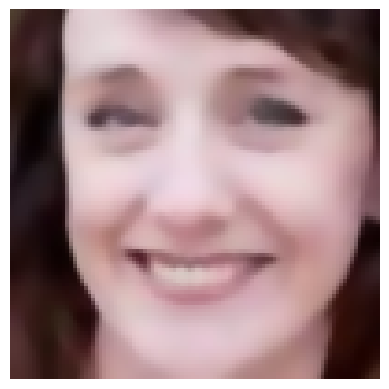

In [87]:
image_index = 12
print("Original Age:", int(FILTEREDy_np.T[0][image_index]))
# predict from model
pred = CNNTwo.predict(np.array([FILTEREDX_np[image_index]]))
pred_eth = etnicity_dict[abs(round(pred[0][0][0])-1)]
pred_age = round(pred[1][0][0])
print("Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(FILTEREDX_np[image_index], cmap='gray');

# **INTERFAZ**

In [44]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os
from keras.models import load_model

class ViewTemplate:
    def __init__(self, mainWindow):
        # self.ventana=Toplevel()
        self.ventana = mainWindow
        self.mainPanel = tk.Canvas(self.ventana, width=600, height=600, highlightthickness=0)

        self.edad = tk.Label(self.ventana, text="Edad real:").place(x=10, y=10)
        self.entry = tk.Entry(self.ventana)
        self.entry.place(x=100, y=10)

        canvas = tk.Canvas(self.ventana, width=250, height=250)
        canvas.place(x=10, y=250)

        self.label = tk.Label(canvas)
        self.label.place(x=0, y=0)

        # Labels para MSE y MAE
        self.MSE = tk.Label(self.ventana, text="MSE: 0.0")
        self.MSE.place(x=10, y=50)
        self.MAE = tk.Label(self.ventana, text="MAE: 0.0")
        self.MAE.place(x=160, y=50)

        # Dropdown menu
        self.options = ["CNNOne RAW", "CNNOne Filter", "CNNTwo Raw", "CNNTwo Filter"]
        self.variable = tk.StringVar(self.ventana)
        self.variable.set(self.options[0])
        self.dropdown = tk.OptionMenu(self.ventana, self.variable, *self.options)
        self.dropdown.place(x=50, y=100)

        # Botón para cargar imagen
        self.button = tk.Button(self.ventana, text="Cargar imagen")
        self.button.place(x=65, y=150)

        self.edadAprox = tk.Label(self.ventana, text="Edad estimada:")
        self.edadAprox.place(x=80, y=200)

        # self.ventana = Canvas(self.venta, background=BACKGROUND, width=WIDTH, height=HEIGHT, highlightthickness=0)
                
        self.loginImage = ""
        self.loginImageLabel = tk.Label(self.mainPanel, image=self.loginImage)
        self.button.bind('<Button-1>', self.load_image)

    def load_image(self, e):
        file_path = filedialog.askopenfilename()
        self.loginImage = self.cargar_img(file_path, 250, 250)
        self.label.config(image=self.loginImage )
        option = self.variable.get()
        if option == "CNNOne RAW":
            Model = load_model('CNNOne_RAW.h5')
        elif option == "CNNOne Filter":
            Model = load_model('CNNOne_FILTER.h5')
        elif option == "CNNTwo Raw":
            Model = load_model('CNNTwo_RAW.h5')
        elif option == "CNNTwo Filter":
            Model = load_model('CNNTwo_FILTER.h5')

        images=[]

        color_image = np.array(io.imread(file_path))/255.0
        color_image = transform.resize(color_image, (100, 100))
        images.append(color_image)

        pred = Model.predict(np.array([images[0]]))
        pred_age = round(pred[1][0][0])

        self.edadAprox.config(text="Edad estimada: "+str(pred_age))

        self.MAE.config(text="MAE: "+str(abs(pred_age-int(self.entry.get()))**(1/2)))
        self.MSE.config(text="MSE: "+str(abs(pred_age**2-int(self.entry.get())**2)**(1/2)))

    def cargar_img(self, nombre, width=0, height=0):
        ruta = os.path.abspath(os.path.join("Views\Assets", nombre)) #crea acceso a la ruta assets dentro de la carpeta del programa
        if not os.path.exists(ruta):
            ruta = os.path.abspath(os.path.join("Assets", nombre))
        img = Image.open(ruta)
        if width != 0 and height != 0:
            img = img.resize((width, height))
        img = ImageTk.PhotoImage(img)
        return img #retorna la imagen 
    
    def build(self):
        self.ventana.mainloop()
    
    def clearFrame(self, window):
        for widget in window.winfo_children():
            widget.destroy()

if __name__ == "__main__":
    window = tk.Tk()
    window.title("TagaPlate")
    window.minsize(600,600) 
    window.resizable(width=tk.NO, height=tk.NO)
    view = ViewTemplate(window)
    view.build()


1/1 [==============================] - 0s 76ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\geogd\AppData\Local\Temp\ipykernel_23608\2294380928.py", line 74, in load_image
    self.MAE.config(text="MAE: "+str(abs(pred_age-int(self.entry.get()))**(1/2)))
                                                  ^^^^^^^^^^^^^^^^^^^^^
ValueError: invalid literal for int() with base 10: ''


1/1 [==============================] - 0s 67ms/step


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Program Files\Python311\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\geogd\AppData\Local\Temp\ipykernel_23608\2294380928.py", line 75, in load_image
    self.MSE.config(text="MSE: "+str(abs(pred_age**2-int(self.entry.get())**2)(1/2)))
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: 'int' object is not callable
